## Regulating a stochastic driven damped harmonic oscillator

Wouter Kouw, last update: 06-11-2022

### System

Consider a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators) with displacement $x(t)$, driving force $u(t)$ and noise $w(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) + w(t)\, ,
\end{align*}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} 
$$
constitute the physical parameters. 

#### Multivariate first-order system

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u + \frac{1}{m} w \, .$$

With the variable substitution $z = [x \ x']$, I cast the above system into a multi-variate first-order form:

$$ \begin{bmatrix} x' \\ x'' \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w\, .$$

#### Discretization

For the Van Loan discretization of the Wiener process, I first consider a first-order approximation of the matrix exponential of the transition matrix: 

$$F(t) = I + \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} t \, .$$

Then, I will consider the continuous-time covariance matrix of the noise in multi-variate form:

$$\mathbb{V}[\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w] = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} \mathbb{V}[w] \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}^{\top} = \begin{bmatrix} 0 & 0 \\ 0 & \frac{\sigma^2}{m^2} \end{bmatrix} \triangleq V \, .$$

Now, I can integrate the evolution of the covariance matrix from over the duration of a time-step. If all time-steps are equally long, e.g., of size $\Delta t$, then

$$Q = \int_0^{\Delta t} F(t) V F(t)^{\top} dt = \frac{\sigma^2}{m^2} \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} \\ \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} & \frac{c^2}{m^2}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} + \Delta t \end{bmatrix} \, ,$$

where $\sigma^2 = \mathbb{V}[w]$. A forward Euler discretization for the state transition yields:

$$\begin{align*} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u_k \, ,
\end{align*}$$

So, we end up with:

$$\begin{align*}
z_k =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \frac{-k}{m} \Delta t & \frac{-c}{m} \Delta t + 1 \end{bmatrix}}_{A} z_{k-1} + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix}}_{B} u_k + q_k \quad \text{where} \quad q_k \sim \mathcal{N}(0,Q) \, .
\end{align*}$$

If we add noisy observations of the displacement position, 

$$ y_k = \underbrace{\begin{bmatrix} 0 & 1 \end{bmatrix}}_{C} z_k + r_k \quad \text{where} \quad r_k \sim \mathcal{N}(0, R) \, .$$

then we have the following probabibilistic state-space model:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid Cz_k, R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [44]:
using Optim
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)

In [182]:
# System parameters
m = 4.0
c = 0.6
k = 1.0
σ = 0.1

# Temporal variables
Δt = 0.05
T  = 400
time = range(0, step=Δt, length=T)

# Matrices
A = [1 Δt; -k/m*Δt -c/m*Δt+1]
B = [0, Δt/m]
C = [1 0]
Q = σ^2/m^2*[Δt^3/3 -c/m*Δt^3/3+Δt^2/2;-c/m*Δt^3/3+Δt^2/2 c^2/m^2*Δt^3/3+Δt^2/2+Δt]
R = 1e-3;

In [183]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = rand(MvNormal(A*z_kmin1 + B*u_k, Q))
    
    # Emit noisy observation
    y_k = rand(Normal(dot(C,z_k), sqrt(R)))
    
    return y_k, z_k
end;

In [187]:
# Control
u = sin.(time .* 2/π)

# Setpoint
z_star = -0.8;

In [188]:
# Initial state
z_0 = [1.0, 1.0]

# Preallocate
z = zeros(2,T)
y = zeros(T)

# Start recursion
z_kmin1 = z_0
for k in 1:T
    
    # Update system
    y[k], z[:,k] = update(z_kmin1, u[k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

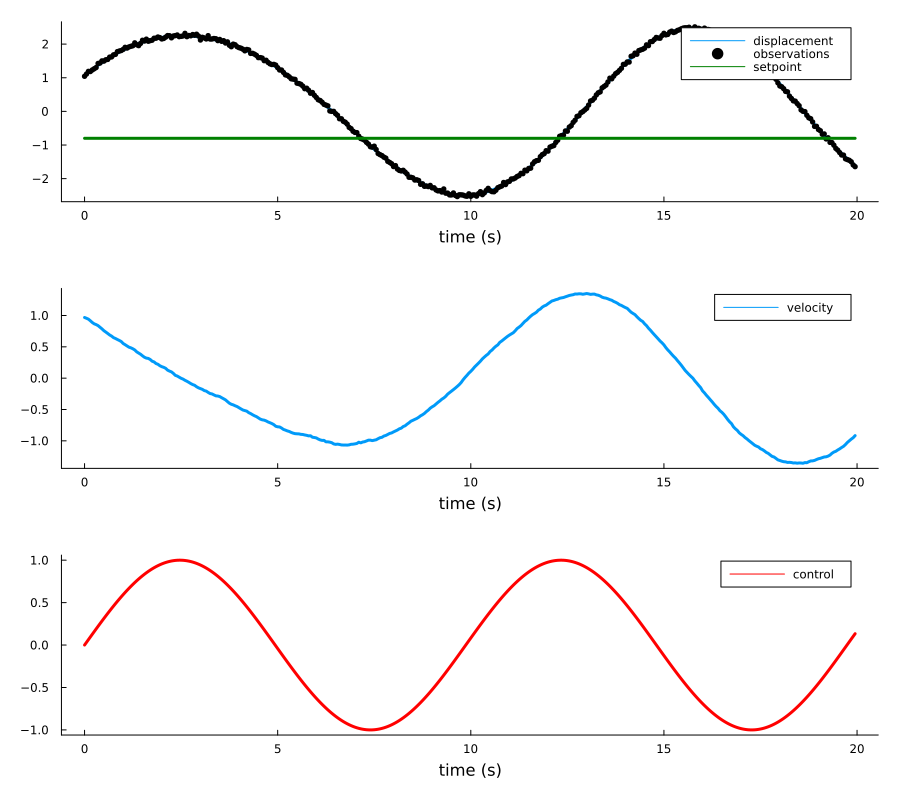

In [189]:
p1 = plot(time, z[1,:], xlabel="time (s)", label="displacement")
scatter!(time, y, color="black", label="observations")
plot!(time, z_star*ones(T), color="green", label="setpoint")
p2 = plot(time, z[2,:], xlabel="time (s)", label="velocity")
p3 = plot(time, u, color="red", xlabel="time (s)", label="control")
plot(p1, p2, p3, layout=(3,1), size=(900,800))

## Baseline: LQR

In [194]:
T  = 1000
time = range(0, step=Δt, length=T)

0.0:0.05:49.95

In [195]:
# Define state-space model
sys = ss(A,B,C,0, Δt)

# Define regulator
L = lqr(sys, Q,R)

# Control law
u_lqr(x,t)  = -L*x .+ z_star

# Simulate
y_sim, t_sim, z_sim, u_out = lsim(sys, u_lqr, time, x0=z_0);

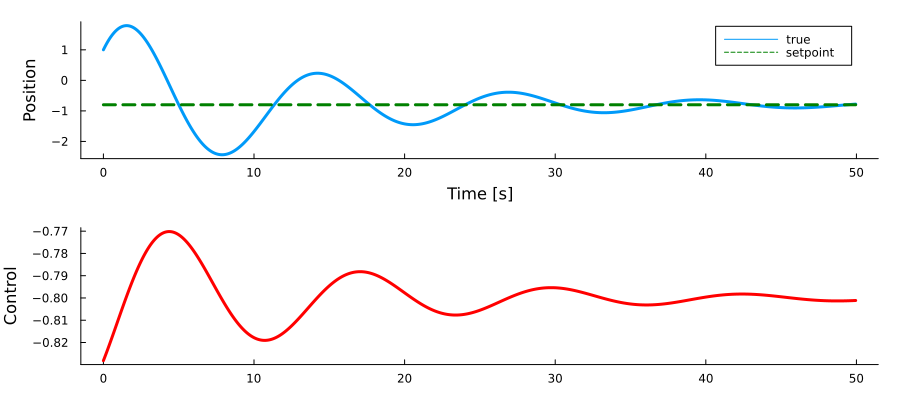

In [196]:
p201 = plot(time, z_sim[1,:], label="true", ylabel="Position", xlabel="Time [s]")
plot!(time, z_star*ones(T), color="green", linestyle=:dash, label="setpoint")
p202 = plot(time, u_out', color="red", ylabel="Control")
plot(p201, p202, layout=(2,1), size=(900,400))

## Expected Free Energy

See [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail. 

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{align*}
p(x,s,u) &= \underbrace{q(s_{t})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{k=t+1}^{t+T} p(x_k|s_k) \cdot p(s_k | s_{k-1}, u_k) p(u_k)}_{\text{GM roll-out to future}}
\end{align*}$$

Consider the Free Energy functional for estimating posterior beliefs $q(s,u)$ over future states and control signals: 
$$\begin{align*}
H[q] &= \overbrace{\sum_{x,s} q(x|s)}^{\text{marginalize }x} \bigg( \overbrace{\sum_u q(s,u) \log \frac{q(s,u)}{p(x,s,u)} }^{\text{variational Free Energy}}\bigg) \\
&= \sum_{x,s,u} q(x,s,u) \log \frac{q(s,u)}{p(x,s,u)}
\end{align*}$$

$$\begin{aligned}
H[q] &= \sum_{x,s,u} q(x,s,u) \log \frac{q(s,u)}{p(x,s,u)} \\
&= \sum_{x,s,u} q(x,s|u) q(u) \log \frac{q(s|u) q(u)}{p(x,s|u) p(u)} \\
&= \sum_{u} q(u) \bigg(\sum_{x,s} q(x,s|u) \log \frac{q(s|u) q(u)}{p(x,s|u) p(u)}\bigg) \\
&= \sum_{u} q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{\sum_{x,s} q(x,s|u) \log \frac{q(s|u)}{p(x,s|u)}}_{G(u)}\bigg) \\
&= \sum_{u} q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) }
\end{aligned}$$


The EFE function for a future observation $t=k+1$ is

$$ G[u_t] = \iint q(y_t \mid z_t) q(z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}u_t \, ,$$

where 

$$\begin{aligned}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{aligned}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$.

We will decompose this EFE function into ambiguity plus risk terms:

$$\begin{aligned}
G(u) &= \sum_{x,s}  q(x,s|u) \log \frac{q(s|u)}{p^\prime(x)p(s|x,u)} \\
&= \sum_{x,s}  q(x,s|u) \log \frac{q(s|u)}{p^\prime(x)} \frac{1}{p(s|x,u)}\\
&= \sum_{x,s}  q(x,s|u) \log \frac{q(s|u)}{p^\prime(x)} \frac{p(x|u)}{p(x|s)p(s|u)} \quad \text{(use Bayes)}\\
&= \sum_{x,s}  q(x,s|u) \log \frac{q(s|u)}{p(x|s)p(s|u)} \frac{p(x|u)}{p^\prime(x)} \\
&= \sum_{x,s}  q(x,s|u) \log \frac{q(s|u)}{p(x|s)p(s|u)} + \sum_{x,s} q(x,s|u) \log \frac{p(x|u)}{p^\prime(x)} \\
&= \sum_{x,s}  p(s|u) p(x|s) \log \frac{\cancel{p(s|u)}}{p(x|s)\cancel{p(s|u)}} + \sum_{x,s} p(s|u) p(x|s) \log \frac{p(x|u)}{p^\prime(x)} \quad \text{( assume }q(x,s|u)=p(x|s)p(s|u)\text{ )}\\
&= \sum_{s}  p(s|u) \sum_x p(x|s) \log \frac{1}{p(x|s)} + \sum_x p(x|u) \log \frac{p(x|u)}{p^\prime(x)} \\
&= \underbrace{E_{p(s|u)}\left[ H[p(x|s)]\right]}_{\text{ambiguity}} + \underbrace{D_{\text{KL}}\left[ p(x|u), p^\prime(x)\right]}_{\text{risk}}
\end{aligned}$$


In [197]:
function EFE(u, state, goal; time_horizon=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, S_star = goal
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0
    for t in 1:time_horizon
        
        # State transition
        m_t = A*m_tmin1 + B*u[t]
        S_t = A*S_tmin1*A' + Q

        # Predicted observation 
        m_pred = dot(C,m_t)
        S_pred = dot(C*S_t,C') + R
        
        # First term of EFE
        ambiguity = 0.5(log(2π) + log(R) - 1)

        # Risk
        diff_m = (m_pred - m_star)
        iS_star = inv(S_star)
        risk = 0.5(log(det(S_star)/det(S_pred)) + 1 + diff_m'*iS_star*diff_m + tr(iS_star*S_pred))
        
        # Cumulate EFE
        cEFE += ambiguity + risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

EFE (generic function with 1 method)

Run through time series and minimize EFE every time step.

In [205]:
T  = 100
time = range(0, step=Δt, length=T)

# Time horizon
TT = 10

10

In [206]:
# Distribution around goal state
goal_state = (z_star, 1e-3)

# Limits of controller
u_lims = (-3.0, 3.0)

# Preallocate
z_est = (zeros(2,T), zeros(2,2,T))
z_sim = zeros(2,T)
y_sim = zeros(T)
u_sim = zeros(T)

# Initial state
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
z_kmin1 = z_0
u_kmin1 = 0.0

@showprogress for k in 1:T
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_kmin1, u_kmin1)
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1
    S_k_pred = A*S_kmin1*A' .+ Q

    # Update step
    K = S_k_pred*C'*inv(dot(C*S_k_pred,C') + R)
    m_k = m_k_pred + K*(y_sim[k] - dot(C,m_k_pred))
    S_k = S_k_pred - K*(dot(C*S_k_pred,C') + R)*K'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u_t) = EFE(u_t, (m_k, S_k), goal_state, time_horizon=TT)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(TT), Fminbox(LBFGS()); autodiff=:forward)
    
    # Extract minimizing control
    u_sim[k] = Optim.minimizer(results)[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    u_kmin1 = u_sim[k]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


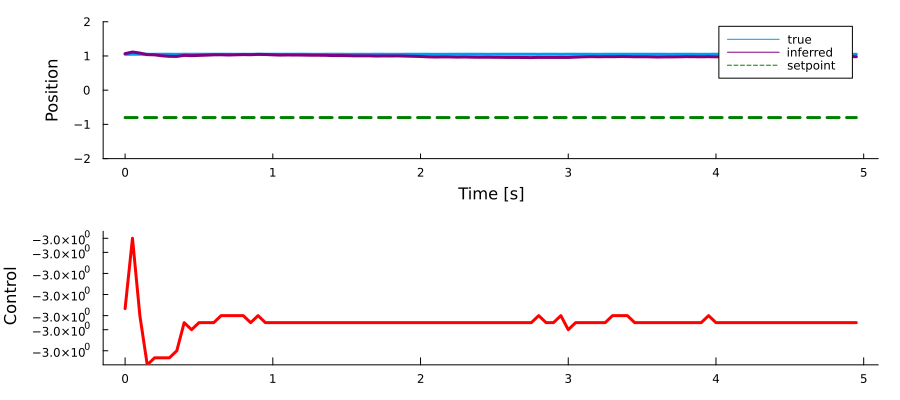

In [207]:
p201 = plot(time, z_sim[1,:], label="true", ylabel="Position", xlabel="Time [s]", ylims=[-2,2])
plot!(time, z_est[1][1,:], label="inferred", color="purple")
plot!(time, z_star*ones(T), color="green", linestyle=:dash, label="setpoint")
p202 = plot(time, u_sim, color="red", ylabel="Control")
plot(p201, p202, layout=(2,1), size=(900,400))

In [208]:
u_sim

100-element Vector{Float64}:
 -2.999999999999433
 -2.9999999999994293
 -2.9999999999994333
 -2.999999999999436
 -2.9999999999994356
 -2.9999999999994356
 -2.9999999999994356
 -2.999999999999435
 -2.999999999999434
 -2.9999999999994342
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
  ⋮
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434
 -2.999999999999434